                              name  count
0                        CANCELLED   1762
1   CALLBACK_SCHEDULED_WITH_CLIENT   1552
2                     SENT_TO_BANK   1112
3                         REJECTED   1067
4                  CANCELLED_BY_RM    724
5                CALLBACK_COMPLETE    464
6                        SUBMITTED    348
7                            TRASH    342
8                DRAFT_APPLICATION    160
9                         APPROVED     32
10                       DISBURSED     20
11             DOCUMENTS_COLLECTED     15
12                  FILE_LOGGED_IN      3


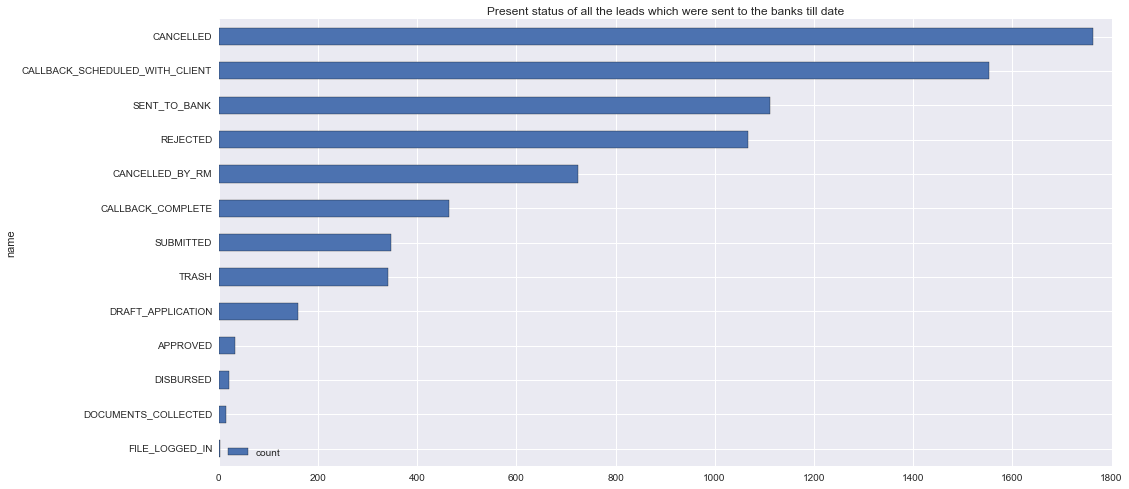

In [116]:
# Present status of all the leads in home loans .

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''select sfs.name , count(distinct(sf.id)) from short_forms sf 
join short_forms_statuses sfs on sfs.id = sf.status_id
join users u on u.id = sf.user_id
 where sf.lead_source_details is not NULL and u.name not like '%estin%'  and sf.status_id <> '1' group by 1 order by 2 desc ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
print df 
df = df.sort('count')
plt.figure(figsize=(16, 8))
ax = plt.gca()
plt.xlabel("Disposition")
plt.ylabel("Count of Leads")
df.plot(x='name',y='count',kind="barh",
       title = 'Present status of all the leads which were sent to the banks till date',ax=ax)
#ax.barh(name, count,color='r',align='center')
# Lot of leads are still stuck up in sent to bank stage , and not being moved by bank for later statges. 

                                       name  count
0                  Loan eligibility problem    268
1                     Property not approved    216
2               Gram Panchayat/ notary land    103
3                      Documents incomplete     73
4                         Risky job profile     49
5           Bank does not fund that product     39
6       Property too old / min. area issues     33
7                    CIBIL or Credit issues     17
8   Already with other agent/duplicate lead      6
9                                    Others      4
10                         Out of Geo Limit      3


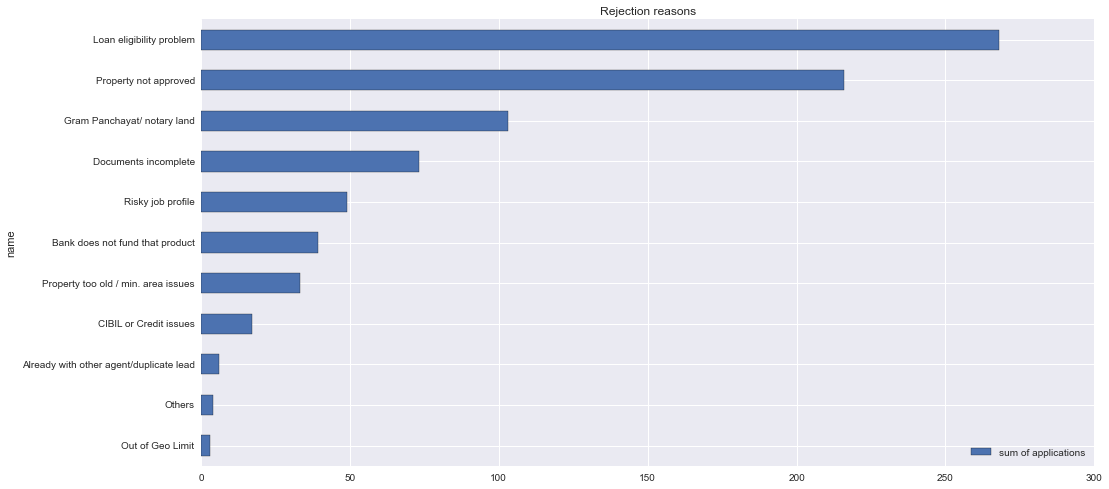

In [21]:
# Rejection reasons and the respective comments .

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''select sr.name , count(distinct(s.short_form_id)) from short_forms_rejection_fields s 
join short_forms_loan_rejection_reasons sr on s.rejection_reason_id = sr.id group by 1 order by 2 desc ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
print df 
df.to_csv('Test.csv')
data = pd.DataFrame(data)
data = pd.read_csv('Test.csv')
data = data.sort('count')
plt.figure(figsize=(16, 8))
ax = plt.gca()
data.plot(x='name', y = 'count',kind="barh" ,legend = True, title = 'Rejection reasons' , ax=ax )


                                          name  count
0                  Don't need a loan presently    324
1         Loan already taken from another bank    137
2             Not interested in the given Bank    124
3            Loan in process with another bank     31
4  Phone not reachable / wrong contact details     11
5                     Not a Home loan customer      9
6            Postponed plan of buying property      4
7    Loan in process with Housing (other bank)      1
8              Dropped plan of buying property      1


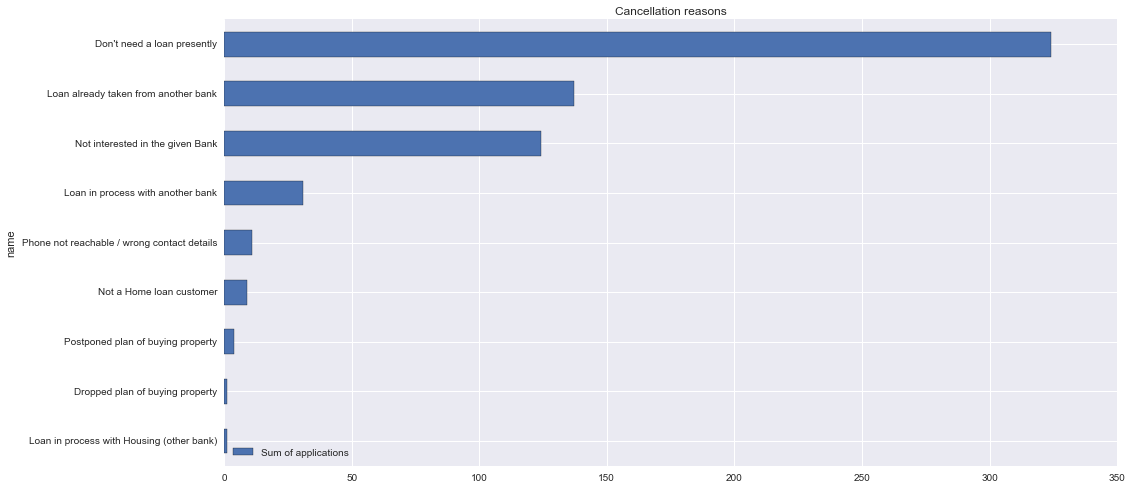

In [22]:
# Cancellation reasons and their respective comments .

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''select sr.name , count(distinct(s.short_form_id)) from short_forms_cancellation_fields s 
join short_forms_loan_cancellation_reasons sr on s.cancellation_reason_id = sr.id group by 1 order by 2 desc ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
print df 
df.to_csv('TestC.csv')
data = pd.DataFrame(data)
data = pd.read_csv('TestC.csv')
data = data.sort('count')
plt.figure(figsize=(16, 8))
ax = plt.gca()
data.plot(x='name', y = 'count',kind="barh" ,legend = True, title = 'Cancellation reasons' ,ax=ax, label = 'Sum of applications')

In [49]:
# applications recieved vs the employment types of users .

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''select sf.id as id , et.name as employment, b.name as bank from short_forms sf 
join employment_types et on et.id = sf.employment_type_id
join products_schemes ps on sf.scheme_id = ps.id 
join products p on p.id = ps.product_id 
join users u on u.id = sf.user_id
join banks b on b.id = p.bank_id where sf.lead_source_details is NOT NULL  and u.email not like '%testing%' order by 1''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
dim = df.groupby('employment').size()
dim = dim.sort('employment')
#final = pd.DataFrame(dim , columns = ['employment','count'])
#dim = dim.sort('count')
print dim 
#dim.plot(x='employment' , y='size',kind = "barh", legend = True , title = 'Employment types', label = 'Sum of applications')

#dimb= df.groupby('bank').size()
#print dimb
#dimb.plot(x='bank' , y='size',kind = "bar", legend = True , title = 'bank split')

None


In [67]:
# Average Monthly Income for all the applications sent to the bank .

cur.execute('''select sf.id , sf.property_cost , et.name as employment_type , sf.monthly_income as income, sf.property_type_id , c.name as city1 , sf.current_total_emi ,sf.loan_amount , sf.tenure , sf.interest_amount , sf.lead_source , 
sf.lead_source_details from short_forms_sent_to_bank_fields s 
join short_forms sf on s.short_form_id = sf.id 
join employment_types et on et.id = sf.employment_type_id 
join cities c on c.id = sf.current_city_id 
''')
columns = [elem[0] for elem in cur.description]
d1 = cur.fetchall()
df1 = pd.DataFrame(d1)
df1.columns = columns 
dim1 = df1.groupby('city1').size()
dimeis = df1.groupby('employment_type').mean()
y=dimeis.income

cur = connect_database()
cur.execute('''select A.* , B.comment from 
(select sf.id , sf.property_cost , et.name as employment_type , sf.monthly_income as income, sf.property_type_id , c.name as city , sf.current_total_emi ,sf.loan_amount , sf.tenure , sf.interest_amount , sf.lead_source , sf.lead_source_details , sr.name as cancellation_reason  from short_forms_cancellation_fields s 
join short_forms_loan_cancellation_reasons sr on s.cancellation_reason_id = sr.id 
join short_forms sf on sf.id = s.short_form_id 
join employment_types et on et.id = sf.employment_type_id
join cities c on c.id = sf.current_city_id  order by 1 desc )A 
join 
(select distinct(A.*) from 
(select short_form_id  as sf_id , comment from short_forms_logs where action_id = '16' order by 1 )A order by 1)B 
on A.id = B.sf_id  ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
dim = df.groupby('city').size()
dimei = df.groupby('employment_type').mean()
x= dimei.income

index = 
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = plt.bar(y.employment_type, y.income, bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config,
                 label='All Applications')

rects2 = plt.bar(x.employment_type + bar_width, x.income, bar_width,
                 alpha=opacity,
                 color='r',
                 error_kw=error_config,
                 label='Cancelled Applications')

plt.xlabel('Employment Type')
plt.ylabel('Income')
plt.title('Monthly Incomes')
#plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
plt.legend()

plt.tight_layout()
plt.show()
#y.plot(x='employment_type' ,y='income' , kind = "bar" , title = 'Average monthly Income of all leads sent to bank')



AttributeError: 'Series' object has no attribute 'employment_type'

In [69]:
print dimei.columns

Index([u'id', u'property_cost', u'income', u'property_type_id',
       u'current_total_emi'],
      dtype='object')


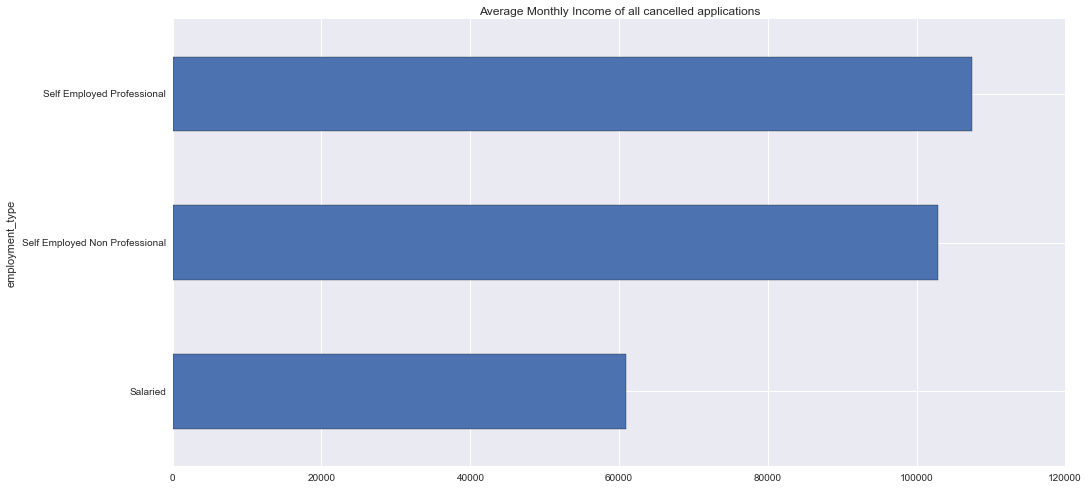

In [59]:
# Average monthly income of Cancelled Applications 
%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

# Extract data for Cancellations .
cur = connect_database()
cur.execute('''select A.* , B.comment from 
(select sf.id , sf.property_cost , et.name as employment_type , sf.monthly_income as income, sf.property_type_id , c.name as city , sf.current_total_emi ,sf.loan_amount , sf.tenure , sf.interest_amount , sf.lead_source , sf.lead_source_details , sr.name as cancellation_reason  from short_forms_cancellation_fields s 
join short_forms_loan_cancellation_reasons sr on s.cancellation_reason_id = sr.id 
join short_forms sf on sf.id = s.short_form_id 
join employment_types et on et.id = sf.employment_type_id
join cities c on c.id = sf.current_city_id  order by 1 desc )A 
join 
(select distinct(A.*) from 
(select short_form_id  as sf_id , comment from short_forms_logs where action_id = '16' order by 1 )A order by 1)B 
on A.id = B.sf_id  ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
dim = df.groupby('city').size()
dimei = df.groupby('employment_type').mean()
x= dimei.income
plt.figure(figsize=(16, 8))
ax = plt.gca()
#ax1=plt.axvline(y.mean(), color='b', linestyle='dashed', linewidth=2)
x.plot(x='employment_type' ,y='income' , kind = "barh" ,ax=ax,title ='Average Monthly Income of all cancelled applications')

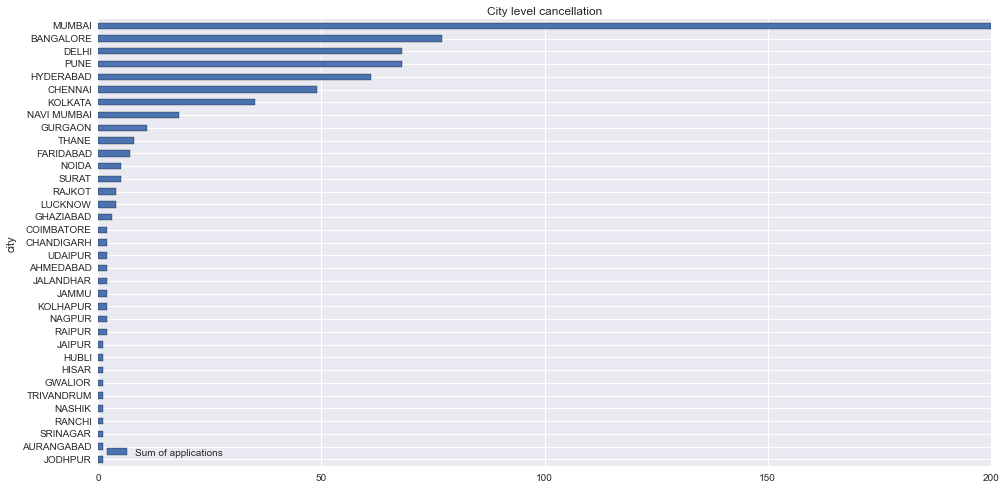

In [17]:
#Cities wise break up of the cancelled applications . Mumbai has many cancellations , but a derived ratio of 
#(cancelled/sent to bank) gives us the true picture . 



#print dimei.property_cost
dim.sort()
dim.to_csv('city_cancellations.csv')
#print dim 
plt.figure(figsize=(16, 8))
#plt.subplot(3,1, 1)
#ax = plt.gca()
dim.plot(x='city' , y='size',kind = "barh", legend = True , title = 'City level cancellation', label = 'Sum of applications')

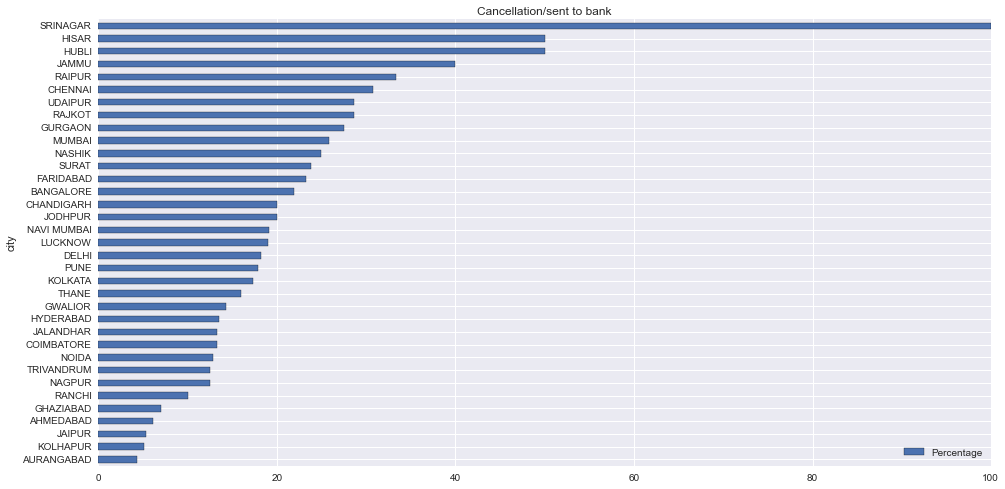

In [51]:
# Graph to calculate the derieved ratios of cancellations and sent to banks .

reader_1 = csv.reader(open('city_submissions.csv','rb'))
reader_2 = csv.reader(open('city_cancellations.csv','rb'))
alist = []
for row in reader_1:
    alist.append(row)
blist = []
for row in reader_2:
    blist.append(row)
c=[]
for a in alist:
    for b in blist:
#         print a, b
        if a[0]==b[0]:
            s = round((float(b[1])/float(a[1]))*100 , 1)
            c.append([a[0],s])
#            print c
final = pd.DataFrame(c , columns = ['city','percentage'])
final = final.sort('percentage')
plt.figure(figsize=(16, 8))
ax = plt.gca()
final.plot(x='city' , y='percentage',kind = "barh", legend = True , title = 'Cancellation/sent to bank', label = 'Percentage' , ax=ax)

In [11]:
reader_1= csv.reader(open("city_cancellations.csv","rb"))
reader_2 = csv.reader(open(("city_submissions.csv","rb"))
                      
                      

SyntaxError: invalid syntax (<ipython-input-11-9d8871a5efdb>, line 4)

In [85]:
# Dump of all the applications and the respective attributes of the leads which were sent to bank . 

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''select sf.id , sf.property_cost , sf.employment_type_id , sf.monthly_income , sf.property_type_id , c.name as city1 , sf.current_total_emi ,sf.loan_amount , sf.tenure , sf.interest_amount , sf.lead_source , 
sf.lead_source_details from short_forms_sent_to_bank_fields s 
join short_forms sf on s.short_form_id = sf.id 
join cities c on c.id = sf.current_city_id 
''')
columns = [elem[0] for elem in cur.description]
d1 = cur.fetchall()
df1 = pd.DataFrame(d1)
df1.columns= columns 

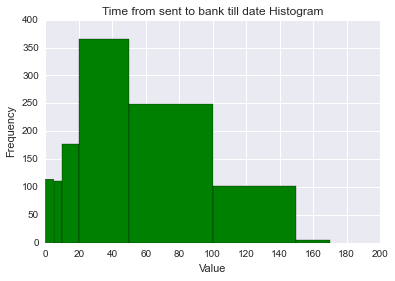

In [89]:
# Median time for each of the applications which are stuck in sent to bank vs which have moved to other stages .
# Histogram of applications which are stuck in sent to bank ( total time taken )

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''select  extract (days from (B.date - B.min )) as time_taken_days from 
(select A.short_form_id , A.min , current_date  from 
(select short_form_id  , min(created_at) from short_forms_logs  where action_id = '7' 
and  short_form_id in (select id from short_forms where status_id = '7' and lead_source_details is not NULL) group by 1 order by 1,2)A order by 1 )B  ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
#print data
df = pd.DataFrame(data)
df.columns = columns
#print df
plt.hist(df['time_taken_days'],bins=[0,5,10,20,50,100,150,170],color='green')
plt.xticks(np.arange(min(df['time_taken_days']), max(df['time_taken_days'])+1, 20))
plt.title("Time from sent to bank till date Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.figure(figsize=(12,8))
plt.show()


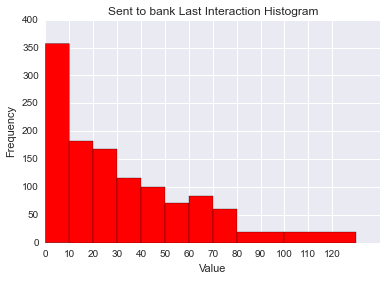

In [14]:
# Time between the current date and the last interaction with the application .
# Histogram .

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''select extract (days from (B.date - B.max )) as last_interaction from 
(select A.short_form_id , A.max , current_date  from 
(select short_form_id  , max(created_at) from short_forms_logs  where action_id = '7' 
and  short_form_id in (select id from short_forms where status_id = '7') group by 1 order by 1,2)A order by 1 )B  ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
#print df 
plt.hist(df['last_interaction'],bins=[0,10,20,30,40,50,60,70,80,100,130],color='red')
plt.xticks(np.arange(min(df['last_interaction']), max(df['last_interaction'])+1, 10))
plt.title("Sent to bank Last Interaction Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.figure(figsize=(20,10))
plt.show()

AttributeError: Unknown property ax

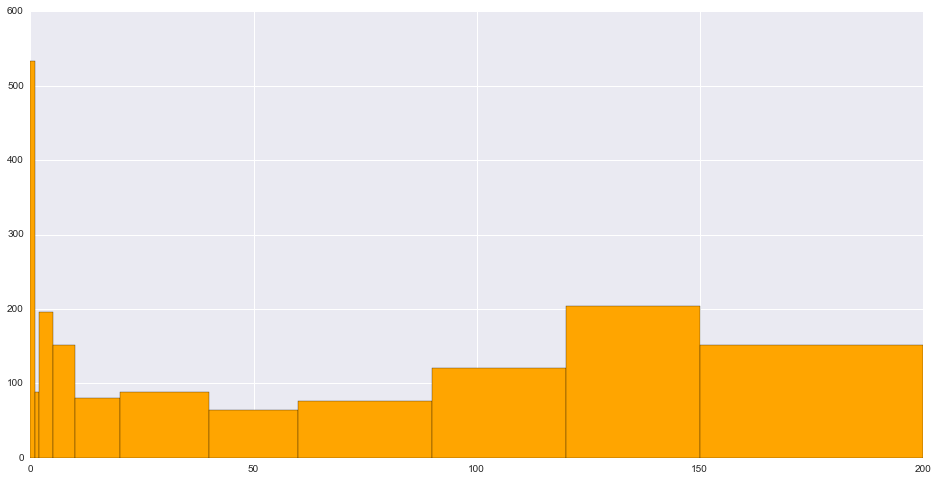

In [101]:
# Bank level time taken for an application in each stage 
# Sent to bank , Cancelled , Rejected 

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute(''' select extract (days from ((A.updated_at) - (A.created_at))) as time from
(select id , created_at , updated_at from short_forms where status_id = '11' and lead_source_details is not NULL )A ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
#print df 

plt.figure(figsize=(16,8))
ax= ax
plt.hist(df['time'],bins=[0,1,2,5,10,20,40,60,90,120,150,200],color='orange',ax=ax)
plt.xticks(np.arange(min(df['time']), max(df['time'])+1, 15))
plt.title("Time taken to get cancelled  Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.figure(figsize=(30,10))
plt.show()

cur = connect_database()
cur.execute(''' select extract (days from ((A.updated_at) - (A.created_at))) as time_rejected from
(select id , created_at , updated_at from short_forms where status_id = '9')A ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
dfr = pd.DataFrame(data)
dfr.columns = columns
#print dfr 

plt.hist(dfr['time_rejected'],bins=[0,10,20,40,60,90,120,150,200],color='violet')
plt.xticks(np.arange(min(dfr['time_rejected']), max(dfr['time_rejected'])+1, 15))
plt.title("Time to get rejected Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.figure(figsize=(30,10))

plt.show()

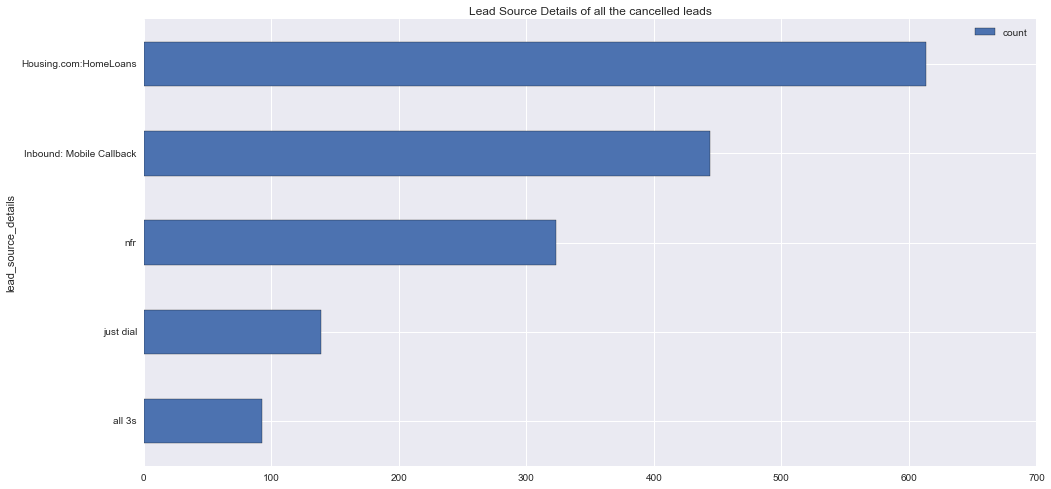

In [40]:
#Cancelled dig up 

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute(''' select A.* from (select lead_source_details , count(distinct(id)) from short_forms where status_id = '11'
and lead_source_details is not NULL  group by 1 order by 1)A where (A.count > '30')''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
df = df.sort('count')
plt.figure(figsize = (16,8))
ax = plt.gca()
df.plot(x='lead_source_details' , y='count',kind = "barh", legend = True ,
        title = 'Lead Source Details of all the cancelled leads ' , ax=ax)

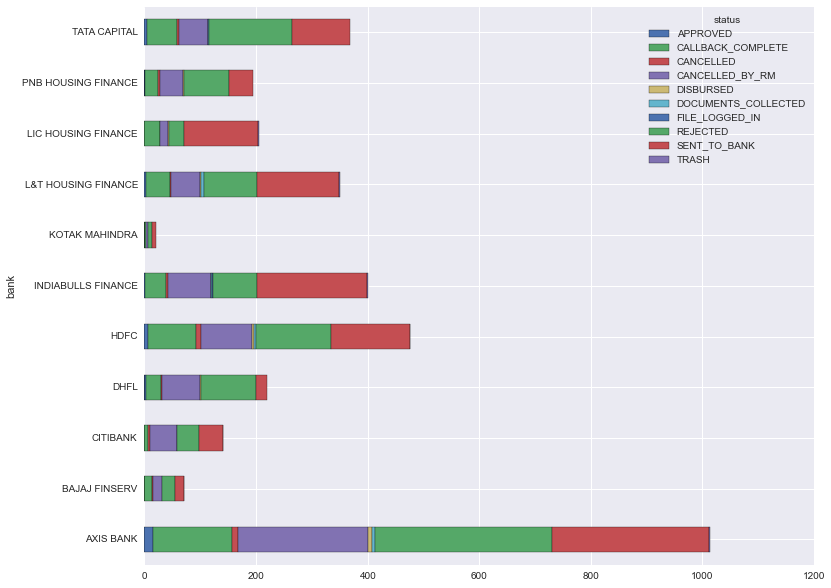

In [41]:
# Bank Wise Comparision 
# Snapshot 

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute(''' select b.name as bank, sfs.name as status, count(sf.id) as count  from short_forms sf
join short_forms_statuses sfs on sfs.id = sf.status_id 
join products_schemes ps on sf.scheme_id = ps.id 
join products p on p.id = ps.product_id 
join banks b on b.id = p.bank_id
where sf.id in (select distinct(short_form_id) from short_forms_logs where action_id = '7')
and b.name not like '%IIFL%'group by 1,2 order by 1,2 ''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
m = [0,50,100,250,300,850,1050]
df_pivot = pd.pivot_table(df, index="bank", columns="status", values="count")
df_pivot.fillna(0, inplace=True)
plt.figure(figsize=(12,10))
ax = plt.gca()
plt.yticks(np.arange(min(m), max(m)+1,75))
df_pivot.plot(kind="barh", stacked=True, ax=ax)


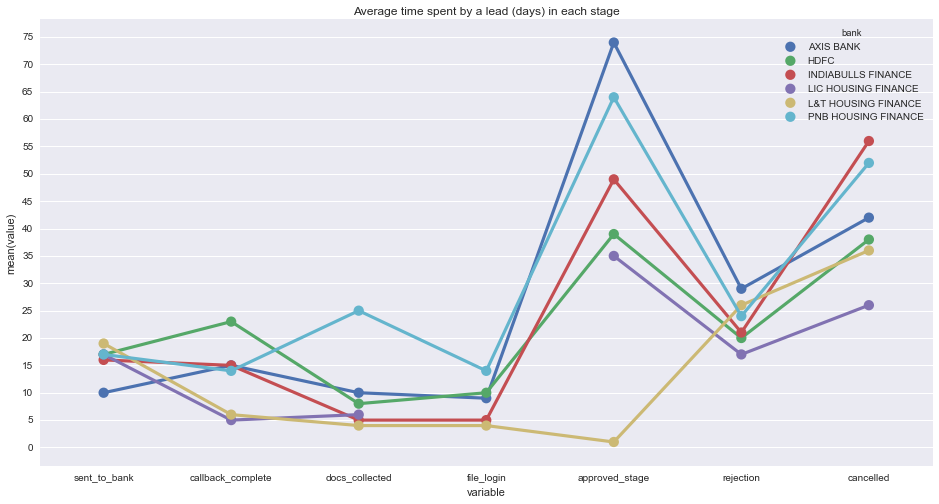

In [61]:
# Average time taken for leads for Banks and Universe 

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute(''' 
select Y.* from 
(select X1.* , X2.callback_complete , X3.Docs_collected , X4.file_login , X5.approved_stage, X6.rejection , X7.cancelled from 
-- sent to bank 
(select D.bank , round(avg(sent_to_bank_stage),0) as Sent_to_bank from
(select C.bank , C.sent_to_bank_stage , C.callback_stage , C.docs_collected_stage , C.file_login_stage , C.approved_stage , C.rejection_stage , C.cancelled_stage from  
(select B.* , (B.callback_date - B.verified) as sent_to_bank_stage , (B.docs_collection_date - B.callback_date) as Callback_stage , (B.file_login_date - B.docs_collection_date) as Docs_collected_stage , (B.approved - B.file_login_date) as file_login_stage , (B.disbursement_date - B.approved) as approved_stage , (B.rejection_date - B.verified) as rejection_stage , (B.cancellation_date - B.verified) as cancelled_stage from 
(select A.*  from  
(select b.name as bank ,sfl.short_form_id , date(sfl.created_at) as verified , date(sfccf.callback_date) as callback_date ,date(sfdcf.date_of_collection) as docs_collection_date , date(sfflf.file_login_date) as file_login_date ,date(sfaf.approval_date) as approved , date(sfdf.disbursement_date) as disbursement_date ,date(sfrf.rejection_date) as rejection_date , date(sfcf.cancellation_date) as cancellation_date from short_forms_logs sfl left join short_forms sf on sfl.short_form_id = sf.id  join products_schemes ps on sf.scheme_id = ps.id  join products p on p.id = ps.product_id join banks b on b.id = p.bank_id join cities c on c.id = sf.current_city_id join users u on u.id = sf.user_id  left join short_forms_callback_complete_fields sfccf on sfccf.short_form_id = sfl.short_form_id left join short_forms_documents_collected_fields sfdcf on sfdcf.short_form_id = sfl.short_form_id left join short_forms_file_logged_fields  sfflf on sfflf.short_form_id = sfl.short_form_id left join short_forms_approved_fields sfaf on sfaf.short_form_id = sfl.short_form_id left join short_forms_disbursed_fields sfdf on sfdf.short_form_id = sfl.short_form_id left join short_forms_rejection_fields sfrf on  sfrf.short_form_id = sfl.short_form_id left join short_forms_cancellation_fields sfcf on sfcf.short_form_id = sfl.short_form_id  where sfl.action_id = '6' order by 4)
A order by 1,2)B )C  where C.sent_to_bank_stage is not NULL  and C.sent_to_bank_stage > '0' order by 1)D group by 1)X1
left join 
--callback stage
(select E.bank , round(avg(E.callback_stage),0) as callback_complete from 
(select C.bank , C.sent_to_bank_stage , C.callback_stage , C.docs_collected_stage , C.file_login_stage , C.approved_stage , C.rejection_stage , C.cancelled_stage from  
(select B.* , (B.callback_date - B.verified) as sent_to_bank_stage , (B.docs_collection_date - B.callback_date) as Callback_stage , (B.file_login_date - B.docs_collection_date) as Docs_collected_stage , (B.approved - B.file_login_date) as file_login_stage , (B.disbursement_date - B.approved) as approved_stage , (B.rejection_date - B.verified) as rejection_stage , (B.cancellation_date - B.verified) as cancelled_stage from 
(select A.*  from  
(select b.name as bank ,sfl.short_form_id , date(sfl.created_at) as verified , date(sfccf.callback_date) as callback_date ,date(sfdcf.date_of_collection) as docs_collection_date , date(sfflf.file_login_date) as file_login_date ,date(sfaf.approval_date) as approved , date(sfdf.disbursement_date) as disbursement_date ,date(sfrf.rejection_date) as rejection_date , date(sfcf.cancellation_date) as cancellation_date from short_forms_logs sfl left join short_forms sf on sfl.short_form_id = sf.id  join products_schemes ps on sf.scheme_id = ps.id  join products p on p.id = ps.product_id join banks b on b.id = p.bank_id join cities c on c.id = sf.current_city_id join users u on u.id = sf.user_id  left join short_forms_callback_complete_fields sfccf on sfccf.short_form_id = sfl.short_form_id left join short_forms_documents_collected_fields sfdcf on sfdcf.short_form_id = sfl.short_form_id left join short_forms_file_logged_fields  sfflf on sfflf.short_form_id = sfl.short_form_id left join short_forms_approved_fields sfaf on sfaf.short_form_id = sfl.short_form_id left join short_forms_disbursed_fields sfdf on sfdf.short_form_id = sfl.short_form_id left join short_forms_rejection_fields sfrf on  sfrf.short_form_id = sfl.short_form_id left join short_forms_cancellation_fields sfcf on sfcf.short_form_id = sfl.short_form_id  where sfl.action_id = '6' order by 4)
A order by 1,2)B )C  where C.callback_stage is not NULL  and C.callback_stage > '0' order by 1)E group by 1)X2
on X1.bank = X2.bank 
left join 
--docs collected
(select F.bank , round(avg(F.Docs_collected_stage),0) as Docs_collected from 
(select C.bank , C.sent_to_bank_stage , C.callback_stage , C.docs_collected_stage , C.file_login_stage , C.approved_stage , C.rejection_stage , C.cancelled_stage from  
(select B.* , (B.callback_date - B.verified) as sent_to_bank_stage , (B.docs_collection_date - B.callback_date) as Callback_stage , (B.file_login_date - B.docs_collection_date) as Docs_collected_stage , (B.approved - B.file_login_date) as file_login_stage , (B.disbursement_date - B.approved) as approved_stage , (B.rejection_date - B.verified) as rejection_stage , (B.cancellation_date - B.verified) as cancelled_stage from 
(select A.*  from  
(select b.name as bank ,sfl.short_form_id , date(sfl.created_at) as verified , date(sfccf.callback_date) as callback_date ,date(sfdcf.date_of_collection) as docs_collection_date , date(sfflf.file_login_date) as file_login_date ,date(sfaf.approval_date) as approved , date(sfdf.disbursement_date) as disbursement_date ,date(sfrf.rejection_date) as rejection_date , date(sfcf.cancellation_date) as cancellation_date from short_forms_logs sfl left join short_forms sf on sfl.short_form_id = sf.id  join products_schemes ps on sf.scheme_id = ps.id  join products p on p.id = ps.product_id join banks b on b.id = p.bank_id join cities c on c.id = sf.current_city_id join users u on u.id = sf.user_id  left join short_forms_callback_complete_fields sfccf on sfccf.short_form_id = sfl.short_form_id left join short_forms_documents_collected_fields sfdcf on sfdcf.short_form_id = sfl.short_form_id left join short_forms_file_logged_fields  sfflf on sfflf.short_form_id = sfl.short_form_id left join short_forms_approved_fields sfaf on sfaf.short_form_id = sfl.short_form_id left join short_forms_disbursed_fields sfdf on sfdf.short_form_id = sfl.short_form_id left join short_forms_rejection_fields sfrf on  sfrf.short_form_id = sfl.short_form_id left join short_forms_cancellation_fields sfcf on sfcf.short_form_id = sfl.short_form_id  where sfl.action_id = '6' order by 4)
A order by 1,2)B )C  where C.Docs_collected_stage is not NULL  and C.Docs_collected_stage > '0' order by 1)F group by 1 )X3
on X1.bank = X3.bank 
left join 
-- File loggedin
(select G.bank , round(avg(G.file_login_stage),0) as file_login from 
(select C.bank , C.sent_to_bank_stage , C.callback_stage , C.docs_collected_stage , C.file_login_stage , C.approved_stage , C.rejection_stage , C.cancelled_stage from  
(select B.* , (B.callback_date - B.verified) as sent_to_bank_stage , (B.docs_collection_date - B.callback_date) as Callback_stage , (B.file_login_date - B.docs_collection_date) as Docs_collected_stage , (B.approved - B.file_login_date) as file_login_stage , (B.disbursement_date - B.approved) as approved_stage , (B.rejection_date - B.verified) as rejection_stage , (B.cancellation_date - B.verified) as cancelled_stage from 
(select A.*  from  
(select b.name as bank ,sfl.short_form_id , date(sfl.created_at) as verified , date(sfccf.callback_date) as callback_date ,date(sfdcf.date_of_collection) as docs_collection_date , date(sfflf.file_login_date) as file_login_date ,date(sfaf.approval_date) as approved , date(sfdf.disbursement_date) as disbursement_date ,date(sfrf.rejection_date) as rejection_date , date(sfcf.cancellation_date) as cancellation_date from short_forms_logs sfl left join short_forms sf on sfl.short_form_id = sf.id  join products_schemes ps on sf.scheme_id = ps.id  join products p on p.id = ps.product_id join banks b on b.id = p.bank_id join cities c on c.id = sf.current_city_id join users u on u.id = sf.user_id  left join short_forms_callback_complete_fields sfccf on sfccf.short_form_id = sfl.short_form_id left join short_forms_documents_collected_fields sfdcf on sfdcf.short_form_id = sfl.short_form_id left join short_forms_file_logged_fields  sfflf on sfflf.short_form_id = sfl.short_form_id left join short_forms_approved_fields sfaf on sfaf.short_form_id = sfl.short_form_id left join short_forms_disbursed_fields sfdf on sfdf.short_form_id = sfl.short_form_id left join short_forms_rejection_fields sfrf on  sfrf.short_form_id = sfl.short_form_id left join short_forms_cancellation_fields sfcf on sfcf.short_form_id = sfl.short_form_id  where sfl.action_id = '6' order by 4)
A order by 1,2)B )C  where C.file_login_stage is not NULL  and C.file_login_stage > '0' order by 1)G group by 1)X4
on X1.bank = X4.bank 
left join 
-- Approved Stage 

(select H.bank , round(avg(H.approved_stage),0) as approved_stage from 
(select C.bank , C.sent_to_bank_stage , C.callback_stage , C.docs_collected_stage , C.file_login_stage , C.approved_stage , C.rejection_stage , C.cancelled_stage from  
(select B.* , (B.callback_date - B.verified) as sent_to_bank_stage , (B.docs_collection_date - B.callback_date) as Callback_stage , (B.file_login_date - B.docs_collection_date) as Docs_collected_stage , (B.approved - B.file_login_date) as file_login_stage , (B.disbursement_date - B.approved) as approved_stage , (B.rejection_date - B.verified) as rejection_stage , (B.cancellation_date - B.verified) as cancelled_stage from 
(select A.*  from  
(select b.name as bank ,sfl.short_form_id , date(sfl.created_at) as verified , date(sfccf.callback_date) as callback_date ,date(sfdcf.date_of_collection) as docs_collection_date , date(sfflf.file_login_date) as file_login_date ,date(sfaf.approval_date) as approved , date(sfdf.disbursement_date) as disbursement_date ,date(sfrf.rejection_date) as rejection_date , date(sfcf.cancellation_date) as cancellation_date from short_forms_logs sfl left join short_forms sf on sfl.short_form_id = sf.id  join products_schemes ps on sf.scheme_id = ps.id  join products p on p.id = ps.product_id join banks b on b.id = p.bank_id join cities c on c.id = sf.current_city_id join users u on u.id = sf.user_id  left join short_forms_callback_complete_fields sfccf on sfccf.short_form_id = sfl.short_form_id left join short_forms_documents_collected_fields sfdcf on sfdcf.short_form_id = sfl.short_form_id left join short_forms_file_logged_fields  sfflf on sfflf.short_form_id = sfl.short_form_id left join short_forms_approved_fields sfaf on sfaf.short_form_id = sfl.short_form_id left join short_forms_disbursed_fields sfdf on sfdf.short_form_id = sfl.short_form_id left join short_forms_rejection_fields sfrf on  sfrf.short_form_id = sfl.short_form_id left join short_forms_cancellation_fields sfcf on sfcf.short_form_id = sfl.short_form_id  where sfl.action_id = '6' order by 4)
A order by 1,2)B )C  where C.approved_stage is not NULL  and C.approved_stage > '0' order by 1)H group by 1 )X5
on X1.bank = X5.bank 
left join 
-- Rejected Stage
(select I.bank , round(avg(I.rejection_stage),0) as rejection from 
(select C.bank , C.sent_to_bank_stage , C.callback_stage , C.docs_collected_stage , C.file_login_stage , C.approved_stage , C.rejection_stage , C.cancelled_stage from  
(select B.* , (B.callback_date - B.verified) as sent_to_bank_stage , (B.docs_collection_date - B.callback_date) as Callback_stage , (B.file_login_date - B.docs_collection_date) as Docs_collected_stage , (B.approved - B.file_login_date) as file_login_stage , (B.disbursement_date - B.approved) as approved_stage , (B.rejection_date - B.verified) as rejection_stage , (B.cancellation_date - B.verified) as cancelled_stage from 
(select A.*  from  
(select b.name as bank ,sfl.short_form_id , date(sfl.created_at) as verified , date(sfccf.callback_date) as callback_date ,date(sfdcf.date_of_collection) as docs_collection_date , date(sfflf.file_login_date) as file_login_date ,date(sfaf.approval_date) as approved , date(sfdf.disbursement_date) as disbursement_date ,date(sfrf.rejection_date) as rejection_date , date(sfcf.cancellation_date) as cancellation_date from short_forms_logs sfl left join short_forms sf on sfl.short_form_id = sf.id  join products_schemes ps on sf.scheme_id = ps.id  join products p on p.id = ps.product_id join banks b on b.id = p.bank_id join cities c on c.id = sf.current_city_id join users u on u.id = sf.user_id  left join short_forms_callback_complete_fields sfccf on sfccf.short_form_id = sfl.short_form_id left join short_forms_documents_collected_fields sfdcf on sfdcf.short_form_id = sfl.short_form_id left join short_forms_file_logged_fields  sfflf on sfflf.short_form_id = sfl.short_form_id left join short_forms_approved_fields sfaf on sfaf.short_form_id = sfl.short_form_id left join short_forms_disbursed_fields sfdf on sfdf.short_form_id = sfl.short_form_id left join short_forms_rejection_fields sfrf on  sfrf.short_form_id = sfl.short_form_id left join short_forms_cancellation_fields sfcf on sfcf.short_form_id = sfl.short_form_id  where sfl.action_id = '6' order by 4)
A order by 1,2)B )C  where C.rejection_stage is not NULL  and C.rejection_stage > '0' order by 1)I group by 1 )X6
on X1.bank = X6.bank 
left join 
-- Cancelled stage 
(select J.bank , round(avg(J.cancelled_stage),0) as cancelled from 
(select C.bank , C.sent_to_bank_stage , C.callback_stage , C.docs_collected_stage , C.file_login_stage , C.approved_stage , C.rejection_stage , C.cancelled_stage from  
(select B.* , (B.callback_date - B.verified) as sent_to_bank_stage , (B.docs_collection_date - B.callback_date) as Callback_stage , (B.file_login_date - B.docs_collection_date) as Docs_collected_stage , (B.approved - B.file_login_date) as file_login_stage , (B.disbursement_date - B.approved) as approved_stage , (B.rejection_date - B.verified) as rejection_stage , (B.cancellation_date - B.verified) as cancelled_stage from 
(select A.*  from  
(select b.name as bank ,sfl.short_form_id , date(sfl.created_at) as verified , date(sfccf.callback_date) as callback_date ,date(sfdcf.date_of_collection) as docs_collection_date , date(sfflf.file_login_date) as file_login_date ,date(sfaf.approval_date) as approved , date(sfdf.disbursement_date) as disbursement_date ,date(sfrf.rejection_date) as rejection_date , date(sfcf.cancellation_date) as cancellation_date from short_forms_logs sfl left join short_forms sf on sfl.short_form_id = sf.id  join products_schemes ps on sf.scheme_id = ps.id  join products p on p.id = ps.product_id join banks b on b.id = p.bank_id join cities c on c.id = sf.current_city_id join users u on u.id = sf.user_id  left join short_forms_callback_complete_fields sfccf on sfccf.short_form_id = sfl.short_form_id left join short_forms_documents_collected_fields sfdcf on sfdcf.short_form_id = sfl.short_form_id left join short_forms_file_logged_fields  sfflf on sfflf.short_form_id = sfl.short_form_id left join short_forms_approved_fields sfaf on sfaf.short_form_id = sfl.short_form_id left join short_forms_disbursed_fields sfdf on sfdf.short_form_id = sfl.short_form_id left join short_forms_rejection_fields sfrf on  sfrf.short_form_id = sfl.short_form_id left join short_forms_cancellation_fields sfcf on sfcf.short_form_id = sfl.short_form_id  where sfl.action_id = '6' order by 4)
A order by 1,2)B )C  where C.cancelled_stage is not NULL  and C.cancelled_stage > '0' order by 1)J group by 1)X7
on X1.bank = X7.bank)Y where Y.bank not like '%TATA%' and Y.bank not like '%KOTAK%' and Y.bank not like '%BAJAJ%' and Y.bank not like '%CITI%' and Y.bank not like '%DHFL%'
''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns 
m = [0,5,10,25,30,85]
colnames = df.columns - ['bank']
df_melt = pd.melt(df, id_vars=['bank'])
plt.figure(figsize=(16, 8))
plt.title("Average time spent by a lead (days) in each stage ")
plt.xlabel("Average Days taken")
plt.ylabel("Stages of Home Loans")
plt.yticks(np.arange(min(m), max(m)+1, 5.0))
ax.axvline(df_melt.value.mean(), color='blue', linewidth=2)
sns.pointplot(x="variable", y="value", hue="bank", data=df_melt)
#plt.axvline(y.mean(), color='b', linestyle='dashed', linewidth=2)



status                         CALLBACK_COMPLETE  CANCELLED  CANCELLED_BY_RM  \
sourcemedium                                                                   
(direct) / (none)                            NaN          5                7   
facebook.com / referral                      NaN        NaN              NaN   
google / cpc                                 NaN        NaN                4   
google / organic                               1          2                9   
nextbigwhat.com / referral                   NaN          1                1   
property.mitula.in / referral                NaN          1              NaN   
rediffmail.com / referral                    NaN        NaN              NaN   
transactional / email                        NaN        NaN                3   

status                         REJECTED  SUBMITTED  TRASH  
sourcemedium                                               
(direct) / (none)                    13          6     13  
facebook.com / refe

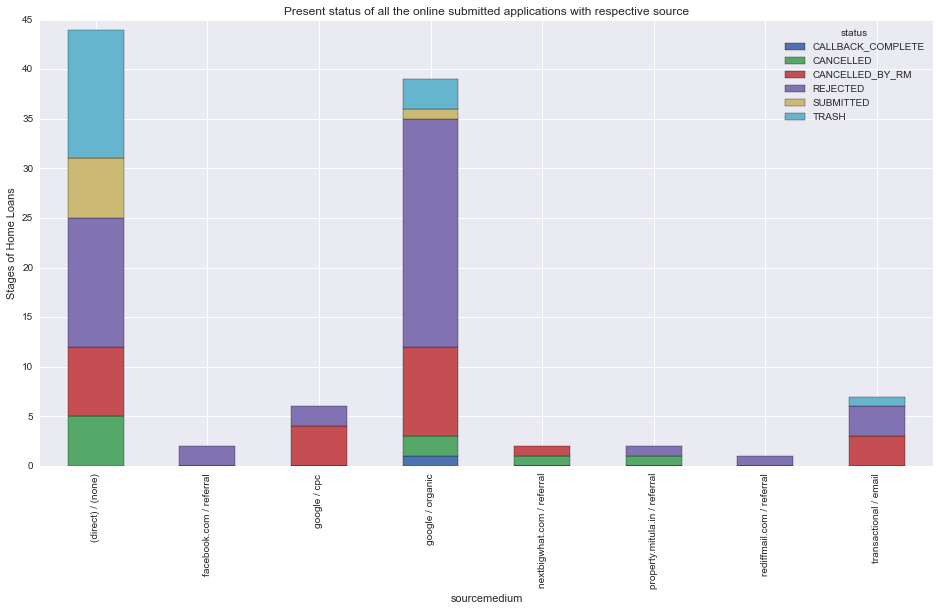

In [117]:
# Marketing campaigns latest statuses .

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute(''' 
select sf.id as sf_id , sf.uuid as uuid, sf.lead_source , sf.lead_source_details , sfs.name as status , 
date(sf.created_at) as created_at , 
date(sf.updated_at) as updated_at from short_forms sf 
join short_forms_statuses sfs on sfs.id = sf.status_id 
where sf.lead_source_details is not NULL and 
sf.id in (select distinct(short_form_id) from short_forms_logs where action_id = '5')order by 5 desc 
''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
#print df 

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_analytics' user='dsl_readonly' host='127.0.0.1' password='dsl' port='5435'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''select city , left(substring(label from (position('d=' in label)+2)),36) as uuid, 
sourcemedium from google_analytics where (action = 'submitted_application' )  ''')
columns = [elem[0] for elem in cur.description]
data1 = cur.fetchall()
dfm = pd.DataFrame(data1)
dfm.columns = columns
#print dfm 

frames = [df,dfm]
result = pd.merge(df,dfm,on='uuid')
resultf = pd.DataFrame(result)
resultf.to_csv('online_split.csv')
#print result 
a=resultf.groupby(['sourcemedium','status']).size().unstack()
final = pd.DataFrame(a)
#final.columns = ['sum']

print final 

# df_pivot = pd.pivot_table(final, index="sourcemedium", columns="status", values="sum")
# df_pivot.fillna(0, inplace=True)
plt.figure(figsize=(16,8))
ax = plt.gca()
#plt.yticks(np.arange(min(m), max(m)+1,75))
# df_pivot.plot(kind="barh", stacked=True, ax=ax)
plt.title("Present status of all the online submitted applications with respective source ")
plt.xlabel("Average Days taken")
plt.ylabel("Stages of Home Loans")
final.plot(kind="bar", stacked=True,ax=ax)


In [129]:
# Break up of online submissions whose documents got collected 

%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_hl_production' user='housing' host='127.0.0.1' password='housing' port='5434'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute(''' 
select sf.uuid as uuid, sfs.name as status from short_forms_documents_collected_fields s 
join short_forms sf on sf.id = s.short_form_id
join short_forms_statuses sfs on sfs.id = sf.status_id
and sf.lead_source_details like '%.com:%' order by 1 
''')
columns = [elem[0] for elem in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = columns
#print df 

def connect_database():
    try:
        conn = psycopg2.connect("dbname='housing_analytics' user='dsl_readonly' host='127.0.0.1' password='dsl' port='5435'")
    except:
        print "Unable to connect to the database"
    cur = conn.cursor()
    return cur

cur = connect_database()
cur.execute('''
select A.city as city, A.uuid as uuid , A.sourcemedium as sourcemedium,
substring(A.campaign from (position(':' in A.campaign)+1)) as campaign from 
(select city ,left(substring(label from (position('d=' in label)+2)),36) as uuid, 
substring((split_part((substring(label from (position('utm_cam' in label)))),',',1))
from (position(':' in ((split_part((substring(label from (position('utm_cam' in label)))),',',1)))))) as campaign, 
sourcemedium from google_analytics where action = 'submitted_application')A  limit 1 ''')
columns = [elem[0] for elem in cur.description]
data1 = cur.fetchall()
dfm = pd.DataFrame(data1)
dfm.columns = columns
#print dfm 

frames = [df,dfm]
result = pd.merge(df,dfm,on='uuid')
resultf = pd.DataFrame(result)
resultf.to_csv('online_split_documents_collected.csv')
print result 
a=resultf.groupby(['campaign','status']).size().unstack()
final = pd.DataFrame(a)
final.columns = ['sum']
print final 

plt.figure(figsize=(16,8))
ax = plt.gca()
plt.title("Campaigns of all online submissions whose documents got collected ")
plt.xlabel("Campaigns")
plt.ylabel("Statuses")
final.plot(kind="bar", stacked=True,ax=ax)


ERROR: An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 85))



KeyboardInterrupt: 